## 🧠 Desafio de Agrupamento com o Iris Dataset

### 🎯 Objetivo
Aplicar técnicas de **aprendizado não supervisionado** para **agrupar as amostras do conjunto de dados Iris** utilizando o algoritmo **K-Means**, com otimização de hiperparâmetros feita via **Optuna**.

---

### 📦 Dataset
O conjunto de dados **Iris** contém 150 amostras de flores de três espécies diferentes: *Setosa*, *Versicolor* e *Virginica*. Cada amostra possui quatro atributos numéricos:

- Comprimento da sépala (sepal length)
- Largura da sépala (sepal width)
- Comprimento da pétala (petal length)
- Largura da pétala (petal width)

- Target:
    - 0: setosa
    - 1: versicolor
    - 2: virginica

Você pode importar o dataset diretamente do `scikit-learn` com o seguinte código:

```python
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data         # Atributos das flores
y = iris.target       # Classes reais (usadas apenas para avaliação)
```



In [260]:
import optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import pairwise_distances, adjusted_rand_score
import plotly.express as px

# Carregando o Iris Dataset

In [261]:
# Carregando o dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_name'] = df['target'].map(dict(enumerate(iris.target_names)))
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

# EDA - Iris Dataset

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [263]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [264]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


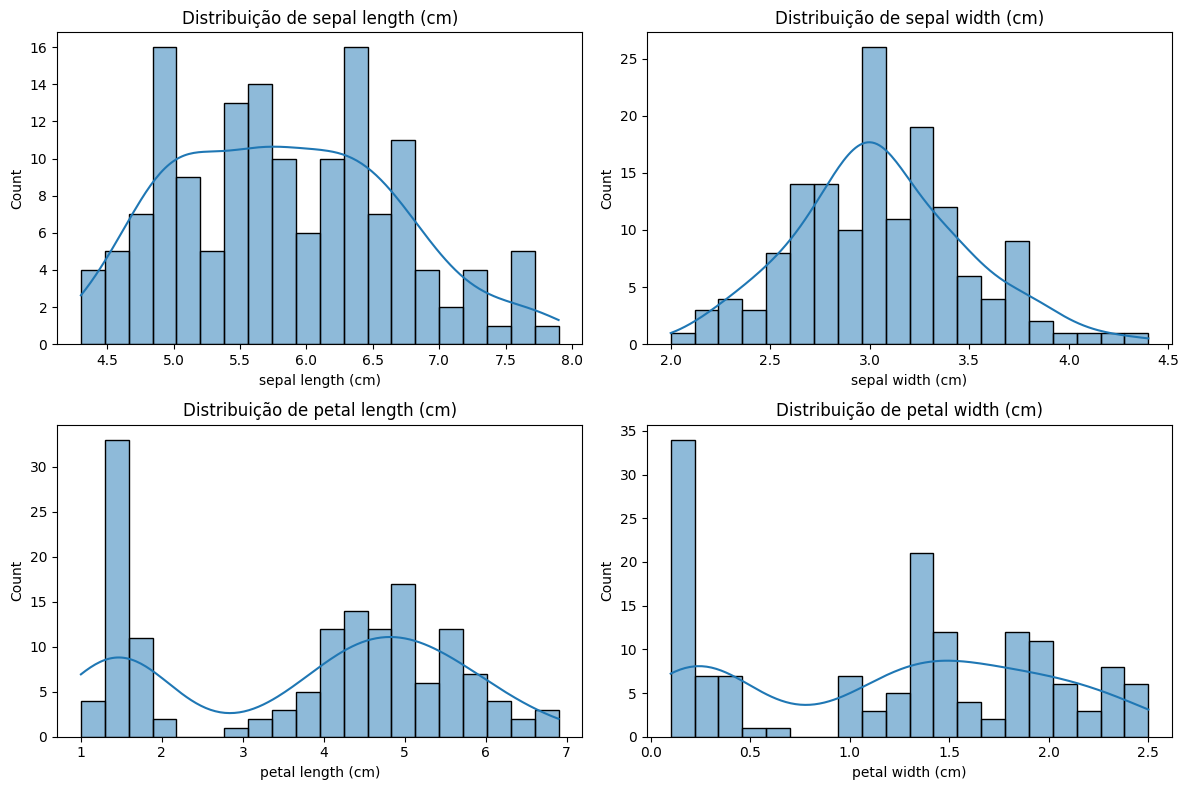

In [265]:
# -------------------------------
# Distribuição das variáveis numéricas
# -------------------------------
plt.figure(figsize=(12, 8))
for i, column in enumerate(iris.feature_names):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f'Distribuição de {column}')
plt.tight_layout()
plt.show()


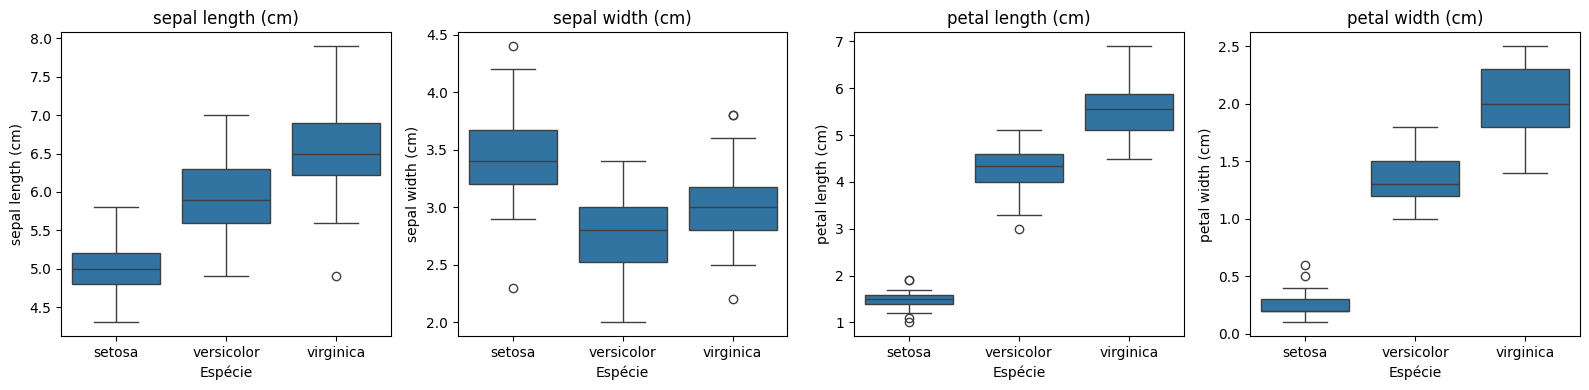

In [266]:
# -------------------------------
# Boxplots por espécie
# -------------------------------
plt.figure(figsize=(16, 4))
features = iris.feature_names
for i, feature in enumerate(features):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x='target_name', y=feature, data=df)
    plt.title(feature)
    plt.xlabel("Espécie")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

Os boxplots apresentados mostram a distribuição das quatro variáveis numéricas do dataset Iris para cada espécie (representada pelo target: 0, 1 e 2).

Principais pontos da análise:

Sepal length (cm):

A espécie 0 (Setosa) possui valores de comprimento de sépala menores e menos dispersos.
As espécies 1 (Versicolor) e 2 (Virginica) apresentam médias e amplitudes maiores, com Virginica tendo os maiores valores.
Sepal width (cm):

Setosa (0) tem, em média, sépalas mais largas, mas com maior variabilidade.
Versicolor (1) apresenta os menores valores de largura de sépala.
Virginica (2) fica em uma posição intermediária.
Petal length (cm):

Setosa (0) se destaca por ter pétalas significativamente mais curtas, com pouca variação.
Versicolor (1) e Virginica (2) têm pétalas mais longas, sendo Virginica a espécie com os maiores valores.
Petal width (cm):


As variáveis relacionadas à pétala (comprimento e largura) são as que melhor separam as espécies, especialmente a Setosa, que é facilmente distinguível das demais. Já as variáveis da sépala apresentam mais sobreposição entre as espécies, principalmente entre Versicolor e Virginica. Isso reforça que as características das pétalas são mais relevantes para a diferenciação das espécies no dataset Iris.

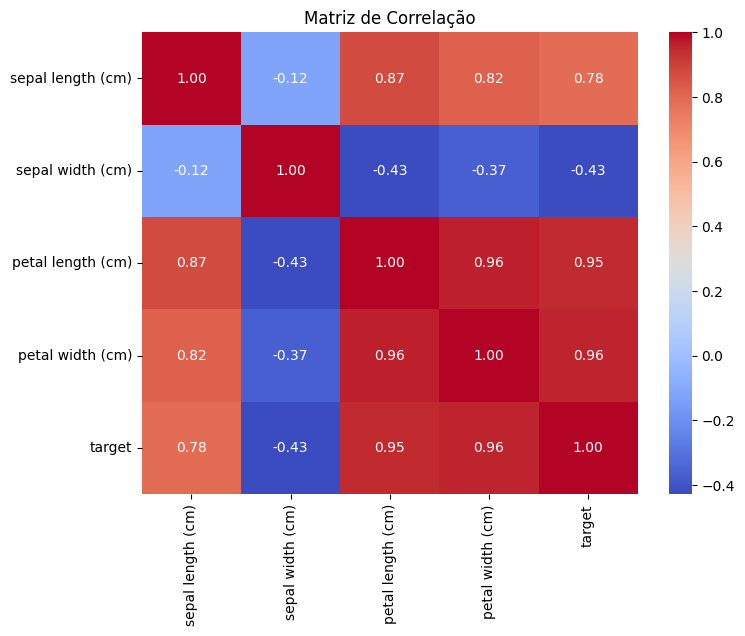

In [267]:
# -------------------------------
# Matriz de correlação
# -------------------------------
plt.figure(figsize=(8, 6))
correlation_matrix = df[iris.feature_names + ['target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação apresentada mostra como as variáveis numéricas do DataFrame df estão relacionadas entre si e com a variável target (espécie da flor).

Principais pontos da análise:

Correlação forte entre comprimento e largura da pétala:
As variáveis petal length (cm) e petal width (cm) possuem uma correlação muito alta (0.96), indicando que flores com pétalas mais longas tendem a ter pétalas mais largas.

Correlação moderada entre comprimento da sépala e características da pétala:
O comprimento da sépala (sepal length (cm)) tem correlação positiva significativa com o comprimento (0.87) e largura (0.82) da pétala.

Largura da sépala pouco correlacionada:
A largura da sépala (sepal width (cm)) apresenta correlação fraca ou negativa com as demais variáveis, sugerindo que ela varia de forma mais independente.

Correlação com o target:
As variáveis de pétala têm alta correlação com o target (0.95 e 0.96), indicando que essas características são importantes para distinguir as espécies.
O comprimento da sépala também tem correlação positiva (0.78) com o target, enquanto a largura da sépala tem correlação negativa moderada (-0.43).

Resumo:
As características das pétalas são as mais relevantes para diferenciar as espécies de flores no dataset, enquanto a largura da sépala tem menor influência na distinção entre as classes.

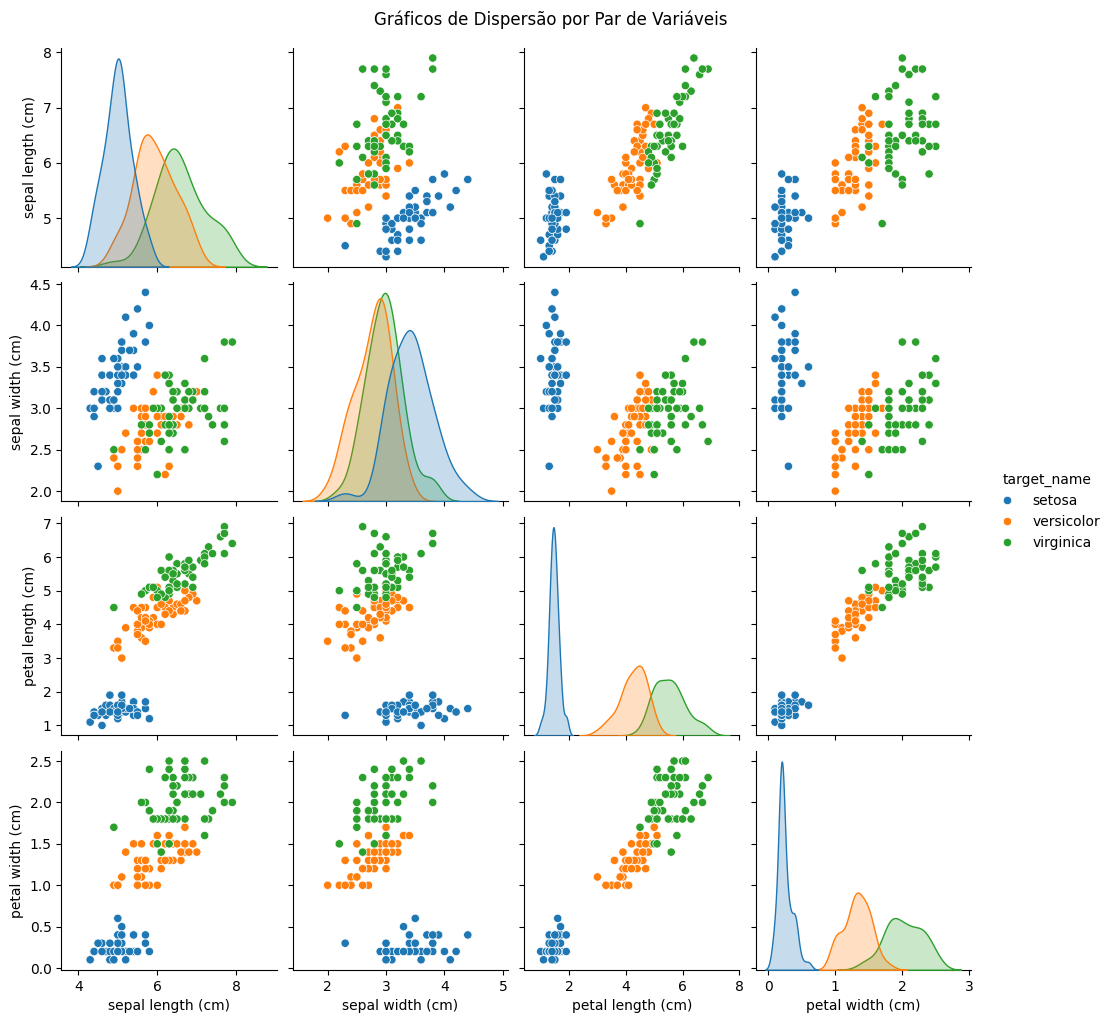

In [268]:
# -------------------------------
# Scatterplot pairwise
# -------------------------------
sns.pairplot(df[iris.feature_names + ['target_name']], hue="target_name", diag_kind="kde", height=2.5)
plt.suptitle("Gráficos de Dispersão por Par de Variáveis", y=1.02)
plt.show()

O gráfico de dispersão (pairplot) mostra a relação entre todas as combinações possíveis das variáveis numéricas do DataFrame df, colorindo os pontos conforme a espécie (target).

Principais observações:

Separação clara da espécie 0:
A espécie 0 (Setosa) está bem separada das demais em praticamente todos os pares de variáveis, especialmente nas variáveis relacionadas à pétala (petal length (cm) e petal width (cm)). Isso indica que essas características são muito distintas para essa espécie.

Sobreposição entre espécies 1 e 2:
As espécies 1 (Versicolor) e 2 (Virginica) apresentam maior sobreposição, principalmente nas variáveis da sépala. No entanto, ao analisar os pares envolvendo comprimento e largura da pétala, é possível observar uma separação mais clara entre elas.

Distribuição das variáveis:
As distribuições nas diagonais mostram que as variáveis de pétala têm distribuições bem distintas para cada espécie, enquanto as variáveis de sépala apresentam mais sobreposição.

Correlação positiva entre variáveis de pétala:
Existe uma forte correlação positiva entre petal length (cm) e petal width (cm), como já indicado pela matriz de correlação.

Resumo:
O pairplot reforça que as variáveis relacionadas à pétala são as mais importantes para diferenciar as espécies de flores, especialmente para separar a Setosa das demais. Já as espécies Versicolor e Virginica são mais semelhantes entre si, mas ainda podem ser diferenciadas analisando as variáveis de pétala.

# Treino do Modelo K-means com todas as features

In [269]:
X = df.drop(columns=['target', "target_name"])
y = df['target']

In [270]:
# Função objetivo para o Optuna
# Como encontrado pelo EDA existe uma grande correlação entre o valores originais e o target, portanto iremos utilizar o valor nativo das features e não iremos normalizar os dados

def kmens_objective(trial):
    # Como para esse exemplo possuimos 3 classes, vamos sugerir um número de clusters entre 3 e 10 (mínimo será 3 podendo ser mais do que isso para melhor associação dos clusters)
    n_clusters = trial.suggest_int('n_clusters', 3, 10)
    
    # Criar o Modelo
    kmeans = KMeans(n_clusters=n_clusters, random_state=51)
    y_predict = kmeans.fit_predict(X)
    
    # Calculando o ARI (Adjusted Rand Index)
    ari = adjusted_rand_score(y, y_predict)
    return ari


In [271]:
# Executando a otimização
search_space = {
    'n_clusters': list(range(3, 11)),  # Testando de 3 a 10 clusters
}

sampler = optuna.samplers.GridSampler(search_space=search_space)
study_kmens = optuna.create_study(direction='maximize', sampler=sampler)

# Rodar o estudo
study_kmens.optimize(kmens_objective, n_trials=100)

[I 2025-06-11 23:02:57,644] A new study created in memory with name: no-name-76a89aa7-b3c8-4ad8-88a0-b5ccec2e9e32
[I 2025-06-11 23:02:57,677] Trial 0 finished with value: 0.6162452219303186 and parameters: {'n_clusters': 4}. Best is trial 0 with value: 0.6162452219303186.
[I 2025-06-11 23:02:57,685] Trial 1 finished with value: 0.6807940871924876 and parameters: {'n_clusters': 5}. Best is trial 1 with value: 0.6807940871924876.
[I 2025-06-11 23:02:57,696] Trial 2 finished with value: 0.4197233759008397 and parameters: {'n_clusters': 10}. Best is trial 1 with value: 0.6807940871924876.
[I 2025-06-11 23:02:57,706] Trial 3 finished with value: 0.4237624913977765 and parameters: {'n_clusters': 9}. Best is trial 1 with value: 0.6807940871924876.
[I 2025-06-11 23:02:57,718] Trial 4 finished with value: 0.6708126818936865 and parameters: {'n_clusters': 6}. Best is trial 1 with value: 0.6807940871924876.
[I 2025-06-11 23:02:57,728] Trial 5 finished with value: 0.4641396540475167 and parameters

In [272]:
# Melhor resultado
print("Melhores parâmetros encontrados:")
print(study_kmens.best_params)

n_cluster = study_kmens.best_params['n_clusters']
best_kmeans = KMeans(n_clusters=n_cluster, random_state=51)
y_best_kmeans = best_kmeans.fit_predict(X)

# Calculando o ARI para o melhor modelo
best_ari = adjusted_rand_score(y, y_best_kmeans)

print(f"Melhor Adjust Rand Index: {best_ari:.4f} com total de clusters '{n_cluster}'")


Melhores parâmetros encontrados:
{'n_clusters': 3}
Melhor Adjust Rand Index: 0.7302 com total de clusters '3'


## Visualizar Resultado

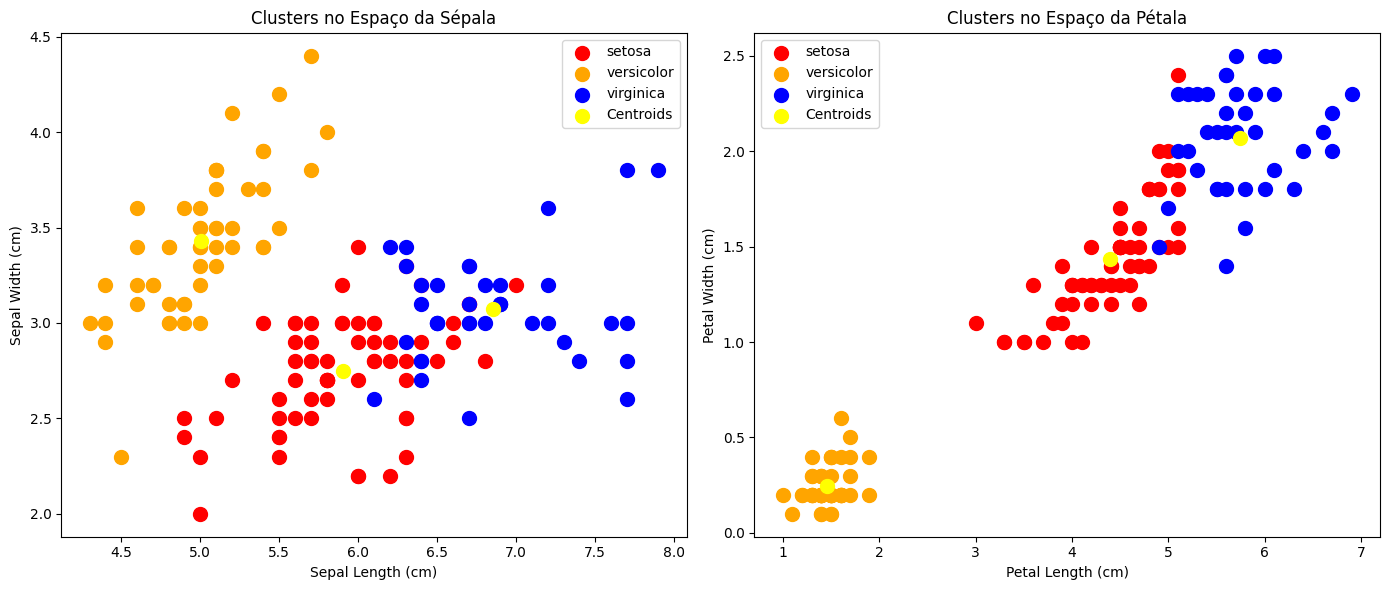

In [273]:
x = X.values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Sépala (sepal length x sepal width)
axes[0].scatter(x[y_best_kmeans == 0, 0], x[y_best_kmeans == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[0].scatter(x[y_best_kmeans == 1, 0], x[y_best_kmeans == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[0].scatter(x[y_best_kmeans == 2, 0], x[y_best_kmeans == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[0].scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
axes[0].set_xlabel("Sepal Length (cm)")
axes[0].set_ylabel("Sepal Width (cm)")
axes[0].set_title("Clusters no Espaço da Sépala")
axes[0].legend()

# Gráfico 2: Pétala (petal length x petal width)
axes[1].scatter(x[y_best_kmeans == 0, 2], x[y_best_kmeans == 0, 3], s=100, c='red', label=iris.target_names[0])
axes[1].scatter(x[y_best_kmeans == 1, 2], x[y_best_kmeans == 1, 3], s=100, c='orange', label=iris.target_names[1])
axes[1].scatter(x[y_best_kmeans == 2, 2], x[y_best_kmeans == 2, 3], s=100, c='blue', label=iris.target_names[2])
axes[1].scatter(best_kmeans.cluster_centers_[:, 2], best_kmeans.cluster_centers_[:, 3], s=100, c='yellow', label='Centroids')
axes[1].set_xlabel("Petal Length (cm)")
axes[1].set_ylabel("Petal Width (cm)")
axes[1].set_title("Clusters no Espaço da Pétala")
axes[1].legend()

plt.tight_layout()
plt.show()

# Treinar o modelo apenas com as variável Petal Length e Petal Width

In [274]:
df2 = df[["petal length (cm)", "petal width (cm)", "target"]] 
X2 = df2.drop(columns=['target'])
y2 = df2['target']

df2

,petal length (cm),petal width (cm),target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0
...,...,...,...
145,5.2,2.3,2
146,5.0,1.9,2
147,5.2,2.0,2
148,5.4,2.3,2


In [275]:
# Função objetivo para o Optuna
# Como encontrado pelo EDA existe uma grande correlação entre o valores originais e o target, portanto iremos utilizar o valor nativo das features e não iremos normalizar os dados

def kmens_objective2(trial):
    # Como nesse exemplo possuimos 3 classes, vamos sugerir um número de clusters entre 3 e 10 (mínimo será 3 podendo ser mais do que isso para melhor associação dos clusters)
    n_clusters = trial.suggest_int('n_clusters', 3, 10)
    
    # Criar o Modelo
    kmeans = KMeans(n_clusters=n_clusters, random_state=51)
    y_predict = kmeans.fit_predict(X2)
    
    # Calculando o ARI (Adjusted Rand Index)
    ari = adjusted_rand_score(y2, y_predict)
    return ari

In [276]:
# Executando a otimização
search_space2 = {
    'n_clusters': list(range(3, 11)),  # Testando de 3 a 10 clusters
}

sampler2 = optuna.samplers.GridSampler(search_space=search_space2)
study_kmens2 = optuna.create_study(direction='maximize', sampler=sampler2)

# Rodar o estudo
study_kmens2.optimize(kmens_objective2, n_trials=100)

[I 2025-06-11 23:02:58,536] A new study created in memory with name: no-name-ff72fa59-f4a6-4fbc-b4bf-d203f7c6759c
[I 2025-06-11 23:02:58,550] Trial 0 finished with value: 0.6843285999114527 and parameters: {'n_clusters': 5}. Best is trial 0 with value: 0.6843285999114527.
[I 2025-06-11 23:02:58,563] Trial 1 finished with value: 0.41306414611907705 and parameters: {'n_clusters': 10}. Best is trial 0 with value: 0.6843285999114527.
[I 2025-06-11 23:02:58,573] Trial 2 finished with value: 0.8856970310281228 and parameters: {'n_clusters': 3}. Best is trial 2 with value: 0.8856970310281228.
[I 2025-06-11 23:02:58,584] Trial 3 finished with value: 0.6034665507591181 and parameters: {'n_clusters': 7}. Best is trial 2 with value: 0.8856970310281228.
[I 2025-06-11 23:02:58,595] Trial 4 finished with value: 0.6400333142407856 and parameters: {'n_clusters': 6}. Best is trial 2 with value: 0.8856970310281228.
[I 2025-06-11 23:02:58,605] Trial 5 finished with value: 0.41979704984004285 and paramete

In [277]:
# Melhor resultado
print("Melhores parâmetros encontrados:")
print(study_kmens2.best_params)

n_cluster2 = study_kmens2.best_params['n_clusters']
best_kmeans2 = KMeans(n_clusters=n_cluster2, random_state=51)
y_best_kmeans2 = best_kmeans2.fit_predict(X2)

# Avaliando melhor resultado
best_ari2 = adjusted_rand_score(y2, y_best_kmeans2)

print(f"Melhor Adjust Rand Index: {best_ari2:.4f} com total de clusters '{n_cluster2}'")


Melhores parâmetros encontrados:
{'n_clusters': 3}
Melhor Adjust Rand Index: 0.8857 com total de clusters '3'


In [278]:
print(f"Melhor Adjust Rand Index 1: {best_ari:.4f} com total de clusters '{n_cluster}'")
print(f"Melhor Adjust Rand Index 2: {best_ari2:.4f} com total de clusters '{n_cluster2}'")

Melhor Adjust Rand Index 1: 0.7302 com total de clusters '3'
Melhor Adjust Rand Index 2: 0.8857 com total de clusters '3'


Fazendo uma redução de dimensionalidade o modelo acabou se ajustando melhor para classificação, tendo assim um resultado melhor utilizando apenas Petal Length e Petal Width do que utilizando todas as features

## Visualizar Resultados para Caso utilizando apenas 2 features (Petal Length e Petal Width)

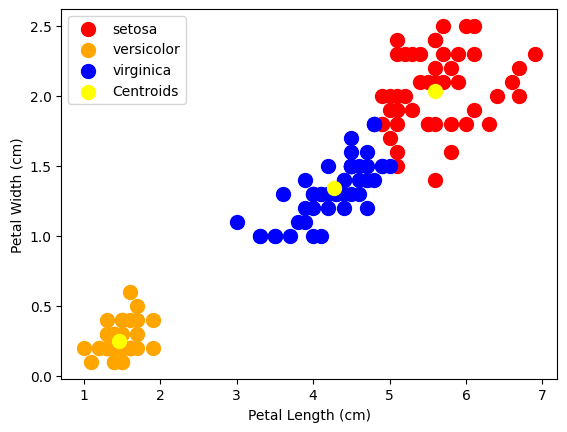

In [279]:
x = df2.iloc[:, [0, 1, 2]].values
plt.scatter(x[y_best_kmeans2 == 0, 0], x[y_best_kmeans2 == 0, 1], 
            s = 100, c = 'red', label=iris.target_names[0])
plt.scatter(x[y_best_kmeans2 == 1, 0], x[y_best_kmeans2 == 1, 1], 
            s = 100, c = 'orange', label=iris.target_names[1])
plt.scatter(x[y_best_kmeans2 == 2, 0], x[y_best_kmeans2 == 2, 1],
            s = 100, c = 'blue', label=iris.target_names[2])

# Plotting the centroids of the clusters
plt.scatter(best_kmeans2.cluster_centers_[:, 0], best_kmeans2.cluster_centers_[:,1], 
            s = 100, c = 'yellow', label = 'Centroids')
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.legend()

### Comparando clustering e classificação predito vs Original utilizando 2 features

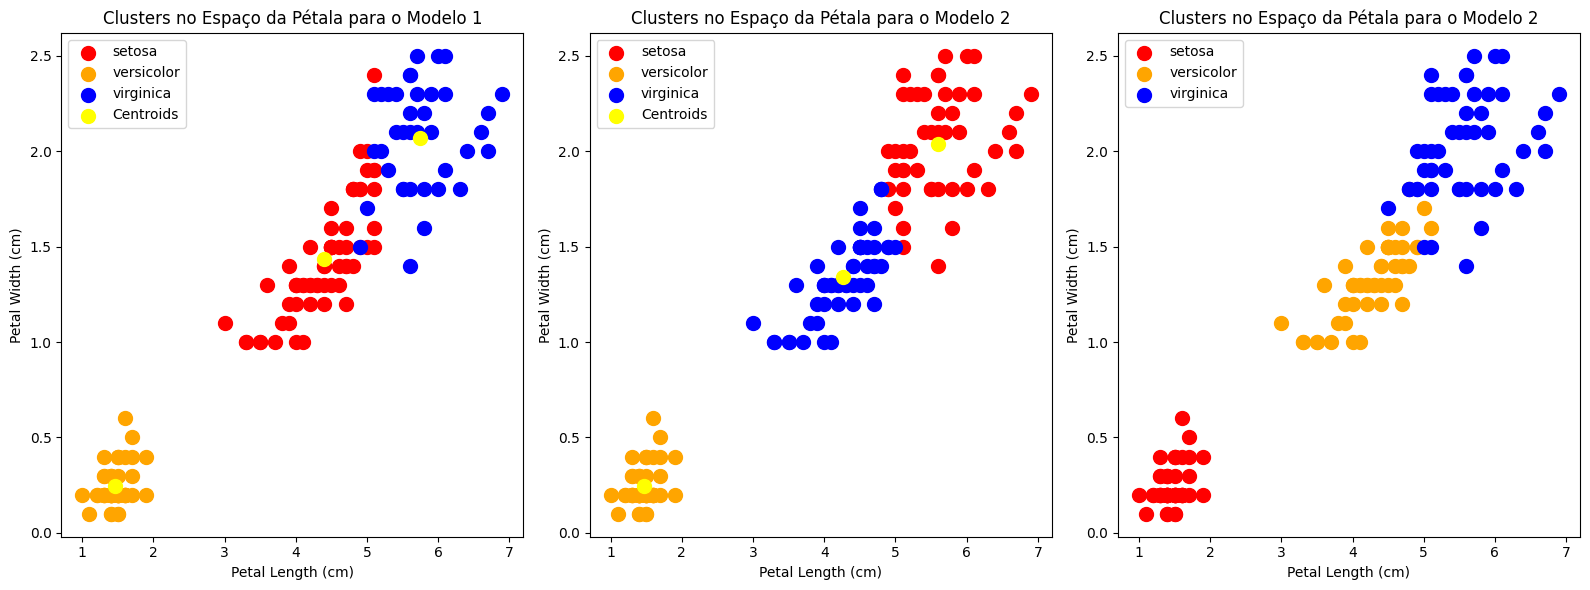

In [280]:
x = X2.values

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Gráfico 1: Pétala do Modelo 1 (petal length x petal width)
axes[0].scatter(x[y_best_kmeans == 0, 0], x[y_best_kmeans == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[0].scatter(x[y_best_kmeans == 1, 0], x[y_best_kmeans == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[0].scatter(x[y_best_kmeans == 2, 0], x[y_best_kmeans == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[0].scatter(best_kmeans.cluster_centers_[:, 2], best_kmeans.cluster_centers_[:, 3], s=100, c='yellow', label='Centroids')
axes[0].set_xlabel("Petal Length (cm)")
axes[0].set_ylabel("Petal Width (cm)")
axes[0].set_title("Clusters no Espaço da Pétala para o Modelo 1")
axes[0].legend()

# Gráfico 2: Pétala do Modelo 2 (petal length x petal width)
axes[1].scatter(x[y_best_kmeans2 == 0, 0], x[y_best_kmeans2 == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[1].scatter(x[y_best_kmeans2 == 1, 0], x[y_best_kmeans2 == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[1].scatter(x[y_best_kmeans2 == 2, 0], x[y_best_kmeans2 == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[1].scatter(best_kmeans2.cluster_centers_[:, 0], best_kmeans2.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
axes[1].set_xlabel("Petal Length (cm)")
axes[1].set_ylabel("Petal Width (cm)")
axes[1].set_title("Clusters no Espaço da Pétala para o Modelo 2")
axes[1].legend()

# Gráfico 2: Pétala do Dataset Real (petal length x petal width)
axes[2].scatter(x[y == 0, 0], x[y == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[2].scatter(x[y == 1, 0], x[y == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[2].scatter(x[y == 2, 0], x[y == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[2].set_xlabel("Petal Length (cm)")
axes[2].set_ylabel("Petal Width (cm)")
axes[2].set_title("Clusters no Espaço da Pétala para o Modelo 2")
axes[2].legend()

plt.tight_layout()
plt.show()

No cenário apresentado nos gráficos, temos uma situação clássica de permutação de rótulos em clustering. O KMeans, por ser um algoritmo não supervisionado, atribui números aos clusters de forma arbitrária, sem se preocupar se o cluster 0 corresponde à classe "setosa", o cluster 1 à "versicolor" ou o cluster 2 à "virginica". Por isso, ao comparar diretamente os rótulos preditos pelo KMeans com os rótulos reais do dataset Iris, podemos encontrar muitos "erros", mesmo quando a separação dos grupos está correta.

Isso é visível nos gráficos: os agrupamentos estão bem definidos, mas as cores (que representam as classes reais) podem não coincidir com os números dos clusters atribuídos pelo modelo. Ou seja, o grupo de pontos vermelhos pode estar rotulado como cluster 2, o laranja como cluster 0, e assim por diante.

**Como resolver esse problema?**

Para avaliar corretamente a performance do clustering, é necessário realinhar os rótulos preditos com os rótulos reais. Isso pode ser feito utilizando o método de atribuição ótima, como o linear_sum_assignment do scipy.optimize, que encontra o melhor mapeamento entre os clusters e as classes verdadeiras. Assim, conseguimos comparar os agrupamentos de forma justa, calculando métricas como acurácia ou matriz de confusão de maneira correta.

Além disso, métricas como o Adjusted Rand Index (ARI) já são robustas a essa permutação, pois avaliam a similaridade entre agrupamentos independentemente dos valores numéricos dos rótulos.

Resumo:

A permutação dos rótulos é natural em clustering e não significa que o modelo está errado.
Para comparar com as classes reais, alinhe os rótulos preditos com os reais usando métodos de otimização.
Use métricas como ARI, que não são afetadas pela ordem dos rótulos dos clusters.

### Alinhando os clusters para verificar acurácia e melhor visualização dos rótulos em gráficos

In [281]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment
def alinhar_clusters(y_true, y_pred):
    # Cria a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    # Encontra o melhor mapeamento entre clusters e classes
    row_ind, col_ind = linear_sum_assignment(-cm)
    # Realinha os rótulos preditos
    y_pred_alinhado = np.zeros_like(y_pred)
    for i, j in zip(col_ind, row_ind):
        y_pred_alinhado[y_pred == i] = j
    return y_pred_alinhado

In [282]:
# Alinhando os clusters do modelo 1
y_best_kmeans_alinhado = alinhar_clusters(y, y_best_kmeans)
# Alinhando os clusters do modelo 2
y_best_kmeans2_alinhado = alinhar_clusters(y, y_best_kmeans2)
# Calculando a acurácia dos modelos alinhados
accuracy_kmeans = accuracy_score(y, y_best_kmeans_alinhado)
accuracy_kmeans2 = accuracy_score(y, y_best_kmeans2_alinhado)
print(f"Acurácia do Modelo 1: {accuracy_kmeans:.4f}")
print(f"Acurácia do Modelo 2: {accuracy_kmeans2:.4f}")

Acurácia do Modelo 1: 0.8933
Acurácia do Modelo 2: 0.9600


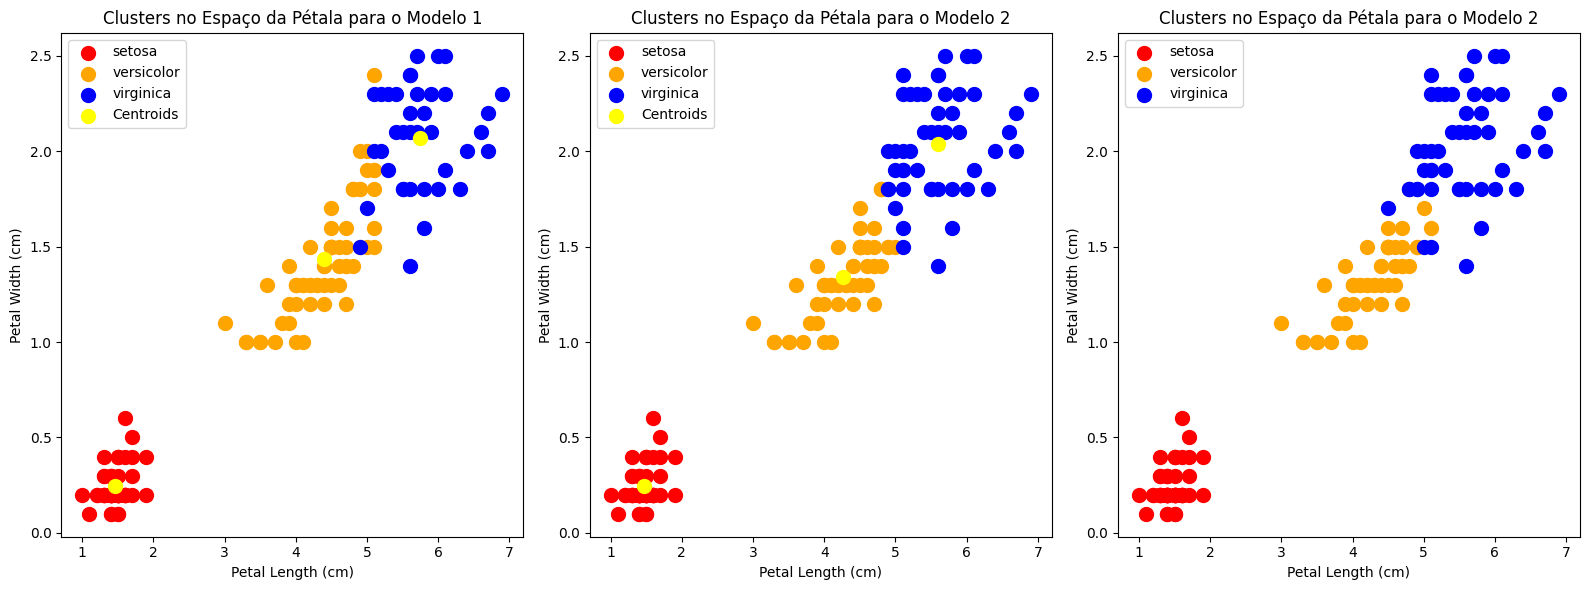

In [283]:
# Visualizando gráficamente os clusters alinhados
x = X2.values

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Gráfico 1: Pétala do Modelo 1 (petal length x petal width)
axes[0].scatter(x[y_best_kmeans_alinhado == 0, 0], x[y_best_kmeans_alinhado == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[0].scatter(x[y_best_kmeans_alinhado == 1, 0], x[y_best_kmeans_alinhado == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[0].scatter(x[y_best_kmeans_alinhado == 2, 0], x[y_best_kmeans_alinhado == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[0].scatter(best_kmeans.cluster_centers_[:, 2], best_kmeans.cluster_centers_[:, 3], s=100, c='yellow', label='Centroids')
axes[0].set_xlabel("Petal Length (cm)")
axes[0].set_ylabel("Petal Width (cm)")
axes[0].set_title("Clusters no Espaço da Pétala para o Modelo 1")
axes[0].legend()

# Gráfico 2: Pétala do Modelo 2 (petal length x petal width)
axes[1].scatter(x[y_best_kmeans2_alinhado == 0, 0], x[y_best_kmeans2_alinhado == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[1].scatter(x[y_best_kmeans2_alinhado == 1, 0], x[y_best_kmeans2_alinhado == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[1].scatter(x[y_best_kmeans2_alinhado == 2, 0], x[y_best_kmeans2_alinhado == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[1].scatter(best_kmeans2.cluster_centers_[:, 0], best_kmeans2.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
axes[1].set_xlabel("Petal Length (cm)")
axes[1].set_ylabel("Petal Width (cm)")
axes[1].set_title("Clusters no Espaço da Pétala para o Modelo 2")
axes[1].legend()

# Gráfico 2: Pétala do Dataset Real (petal length x petal width)
axes[2].scatter(x[y == 0, 0], x[y == 0, 1], s=100, c='red', label=iris.target_names[0])
axes[2].scatter(x[y == 1, 0], x[y == 1, 1], s=100, c='orange', label=iris.target_names[1])
axes[2].scatter(x[y == 2, 0], x[y == 2, 1], s=100, c='blue', label=iris.target_names[2])
axes[2].set_xlabel("Petal Length (cm)")
axes[2].set_ylabel("Petal Width (cm)")
axes[2].set_title("Clusters no Espaço da Pétala para o Modelo 2")
axes[2].legend()

plt.tight_layout()
plt.show()